# Analyzing A/B Test Results 

In this project we will analyze A/B test results in a data called "ab_data" that is including some experiments about various customers based on e-commerce website affairs. This project is also organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should:

- Implement the new webpage, 
- Keep the old webpage,
- Or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### Data Description 

Below is the description of our ab_data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


### Exploring The Dataset

In [ ]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.shape[0]

294478

In [ ]:
df['user_id'].nunique()

290584

The proportion of users converted :

In [ ]:
len(df[df.converted==1])/len(df.converted)

0.11965919355605512

The number of times when the "group" is `treatment` but "landing_page" is not a `new_page` ('old_page') and the "group" is 'control' but "landing_page" is 'new_page' :

In [ ]:
len(df.query("group=='treatment' and landing_page == 'old_page'") + df.query("group=='control' and landing_page == 'new_page'"))

3893

Checking Missing Values

In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 294478 entries, 0 to 294477

Data columns (total 5 columns):

 #   Column        Non-Null Count   Dtype 

---  ------        --------------   ----- 

 0   user_id       294478 non-null  int64 

 1   timestamp     294478 non-null  object

 2   group         294478 non-null  object

 3   landing_page  294478 non-null  object

 4   converted     294478 non-null  int64 

dtypes: int64(2), object(3)

memory usage: 11.2+ MB


In [ ]:
df.isnull().values.any()

False

### Creating The New Dataframe

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |

It means, the `control` group users should match with `old_page`; and `treatment` group users should match with the `new_page`. However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old webpage.

In [ ]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

df2 = df.query("group == 'control' and landing_page == 'old_page'")
df2 = df2.append(df.query("group == 'treatment' and landing_page == 'new_page'"))
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [ ]:
# Double Check all of the incorrect rows were removed from df2 
# Output of the statement below should be 0

df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

#### Exploring Our New DataFrame (df2)

In [ ]:
df2.user_id.nunique()

290584

In [ ]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [ ]:
#user_id =773192
df2[df2.user_id==773192] 

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [ ]:
#Removing one of the rows with a duplicate user_id and checking again if the row with a duplicate user_id is deleted or not
df2 = df2.drop(2893)

In [ ]:
'2893' in df.index #Checking the dropped id. 

False

In [ ]:
df2.converted.mean() #Probability of an individual converting regardless of the page they receive

0.11959708724499628

In [ ]:
cont_prob = df2.query("group == 'control'")['converted'].mean() #Given that an individual was in the control group, the probability they converted
cont_prob

0.1203863045004612

In [ ]:
treat_prob=df2.query("group=='treatment'")['converted'].mean() #Given that an individual was in the treatment group, the probability they converted
treat_prob

0.11880806551510564

In [ ]:
# Calculating the actual difference (obs_diff observed difference) between the conversion rates for the two groups.
obs_diff=cont_prob-treat_prob
obs_diff

0.0015782389853555567

#### Checking The Probability That An Individual Received The New Page

In [ ]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

Now we can explain that whether or not the new `treatment` group users lead to more conversions. When we look at the probabilities of treat_prob and cont_prob we don't see any significant difference as we calculated above too. We can see in here that the new page led to a lower conversion rate.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, we consider that we need to make the decision just based on all the data provided. Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page.

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% (Type I error means rejecting the null hypothesis when it's actually true), what should be our null and alternative hypothesis (**$H_0$** and **$H_1$**)?  

We can state our hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

**We can define our null hypothesis H0 as pnew=pold, and our alternative H1 as pnew>pold.**

#### Null Hypothesis $H_0$ Testing

Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is:
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 
- Use a sample size for each group equal to the ones in the `df2` data.
- Compute the difference in the "converted" probability for the two samples above. 
- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations and calculate an estimate.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [ ]:
null_prob = df2['converted'].mean()
null_prob

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [ ]:
null_prob #Under the null hypothesis pnew=pold

0.11959708724499628

**c.** What is $n_{new}$ (the number of individuals) in the treatment group?

In [ ]:
new_number = df2.query("landing_page == 'new_page'").shape[0] #The treatment group users are shown the new page.
new_number

145310

**d.** What is $n_{old}$ the number of individuals in the control group?

In [ ]:
old_number = df2.query("landing_page == 'old_page'").shape[0] #The control group users are shown the old page.
old_number

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions (new_number) with a conversion rate of $p_{new}$ under the null hypothesis. Store these $n_{new}$ 1's and 0's in the new_page_converted numpy array.

In [ ]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.binomial(1, null_prob, new_number) #binomial(n, p, size=None) n number of trials, p probability of each trial
new_page_converted

#We could use `numpy.random.choice()` method also to randomly generate n_new values in here too. 
#And then we can store these n_new 1's and 0's in the `new_page_converted` numpy array.

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions (old_number) with a conversion rate of $p_{old}$ under the null hypothesis.Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [ ]:
# Simulate a Sample for the control Group
old_page_converted = np.random.binomial(1, null_prob, old_number)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [ ]:
diff=(new_page_converted.mean()-old_page_converted.mean())
diff

0.001959619641316579


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above.

Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [ ]:
# Sampling distribution
p_diffs = []

new_converted = np.random.binomial(new_number,null_prob,10000)/new_number
old_converted = np.random.binomial(old_number,null_prob,10000)/old_number
p_diffs = new_converted-old_converted
p_diffs

array([ 0.00150529,  0.00025939,  0.00075501, ...,  0.00138823,
       -0.00042887,  0.00019765])

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**. We use `plt.axvline()` method to mark the actual difference observed in the `df2` data (recall `obs_diff`) in the chart. We can display title, x-label, and y-label in the chart also.

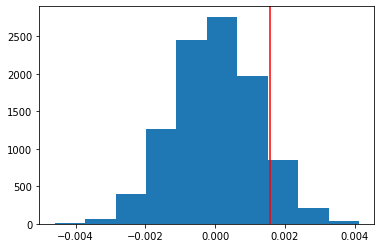

In [ ]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='red');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

1.8035


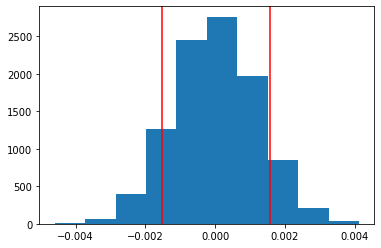

In [ ]:
obs_diff = cont_prob-treat_prob

high = (p_diffs.mean() + (p_diffs.mean() - obs_diff) < p_diffs).mean()
low = (p_diffs < obs_diff).mean()

plt.hist(p_diffs)
plt.axvline(obs_diff, color='red')
plt.axvline(p_diffs.mean() + (p_diffs.mean() - obs_diff), color='red')
p_val = high+low
print(p_val)

**k.** Now we will explain in words what we have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? ("Comparing the value above with the "Type I error rate (0.05)")

Firstly, we see that **the alpha (æ) parameter is 0.05** in here. (Type 1 error rate).

We calculated the p-value in here (1.81). **So our p-value is bigger than the alpha (æ) parameter (p-value>0.05).** And this means that we do not have evidence to reject the null hypothesis. (Our null hyptothesis was pnew=pold as we defined above.)

If we would see that the value of p under 0.05 (p<0.05) this would be a sign of low probability of the null hypothesis' s trueness.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

First we need the values in the statements below to calculate:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [ ]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()

# number of individuals who were shown the old_page
n_old= df2.query("landing_page == 'old_page'").shape[0]

# number of individuals who received new_page
n_new= df2.query("landing_page == 'new_page'").shape[0]

In [ ]:
print(convert_old, convert_new, n_old, n_new)

17489 17264 145274 145310


**m.** Now we will use `sm.stats.proportions_ztest()` to compute our test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. That is :

It's a two-tailed (two-sided) if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed (smallar) if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed (larger) if you defined $H_1$ as $(p_{new} > p_{old})$. In here our alternative (H1) is pnew>pold.

The built-in function above will return the z_score and p_value.

---
### About The Two-Sample Z-Test
Recall that we have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for our two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,

- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{old}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)

Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error.

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected if the $Z_{score}$ lies in that region.

For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$.

For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$.

In [ ]:
import statsmodels.api as sm

# Calculating the z_score and p_value with the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])

print(z_score, p_value)

1.3109241984234394 0.18988337448195103


**n.** What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In here we see the difference between our test statistic and the null hypothesis as z-score that is 1.31 therefore we would not need to reject the null with this solution. To put it more clearly, our Z-alpha score (Z-0.05) is 1.645 (Because our test is one tailed test). For a right tailed test we reject null if Z-score>Z-alpha. But our Z-score is 1.31 and is not bigger than Z-alpha.

And this p-value (0.189) is similar to the p-value before (0.199) We can say that the z-test appears to agree with the previous observations. Plus, the type 1 error rate is not bigger than our p_value in here too. (It was 0.05 and our p_value in here is 0.189) 

<a id='regression'></a>
### Part III - A regression approach

In this this part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

**We need to use logistic regression in here because we want to define the conversions.**

**b.** The goal is to use **statsmodels** library to fit the regression model we specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, firstly we need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [ ]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [ ]:
df2['intercept'] = 1
df2[['a_page', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('a_page', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


**c.** Using **statsmodels** to instantiate our regression model on the two columns created in part (b). above, then fitting the model to predict whether or not an individual converts. 

In [ ]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.

         Current function value: 0.366118

         Iterations 6


**d.** Provide the summary of the model below.

In [ ]:
results.summary2() #Logistic regression, so in here we use summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-06-04 15:21 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

- What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- We may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided and we may also compare the current p-value with the Type I error rate (0.05).

In here the model shows us the prediction whether or not the user will convert depending on the page. The null is ab_page =1, converted =0, the alternative is ab_page=1 and converted is 1. And the p-value associated with ab_page is 0.190 in here.

**f.** Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

In here it does not appear that treatment or control page might influence whether or not an individual converts. And if we add another factor in this problem it may be a good idea to see the impact of this value / values on the prediction. **But we have to keep in our mind that the factors should not have multicollinearity amongst them too.**

**g. Adding Countries To Our Dataframe**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. We need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. **We will will utilize two columns for the three dummy variables in here.**

In [ ]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [ ]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


In [ ]:
# Join with the df2 dataframe
df2=df2.set_index('user_id').join(countries.set_index('user_id'))
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [ ]:
# Create the necessary dummy variables
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1


**h. Fitting The Model and Obtain The Results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Now we will create the necessary additional columns, and fit the new model.**

- We will look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can we reject/fail to reject the null hypothesis ? (Our regression model ?)

In [ ]:
# Fitting the model and summarize the results
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.

         Current function value: 0.366113

         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-06-04 15:21 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In countries **US** is our baseline in this calculation and when we check the p-values above, we see that country has not a significant impact on conversions.

Notwithstanding there is not a remarkable impact on conversions, now we would calculate the interaction or multicollinearity between these values. 

In [ ]:
df2['CA_conv'] = df2['CA']*df2['ab_page']
df2['UK_conv'] = df2['UK']*df2['ab_page']
df2['US_conv'] = df2['US']*df2['ab_page']

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'CA_conv', 'UK_conv']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.

         Current function value: 0.366113

         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212779.0384
Date:               2022-06-04 15:21 BIC:              212810.7773
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.080850   
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9963    0.0062  -322.0487  0.0000  -2.0084  -1.9841
CA_conv      -0.0752    0.0376    -1.9974  0.0458  -0.1489  -0.0014
UK_conv       0.0149    0.0173     0.8617  0.3888  -0.0190   0.0488
==================================================================

"""

In here we can see that p value of CA_conv is 0.0458 and it is smaller than the alpha value (Type 1 Error) This means that we have a statistically significant on CA_conv and ab_page. ???????????????

In [ ]:
np.exp(results.params)

intercept    0.135840
CA_conv      0.927579
UK_conv      1.015000
dtype: float64

In [ ]:
print(1/0.927579) #Because CA_conv coef. is negative above.

1.0780752906221465


With this 1.07 value we can interpret that the CA_conv users are more likely to convert than the US_conv users about 1.078 times. 

It is interesting that ab_page and the countries we calculated are not significant with each other but when we defined the multicollinearities between them we can see the significance between CA_conv and ab_page also.

At the end we can say that there is no reason to change our page from old to the new one. Because we do not have enough values, evidences based on our calculations to reject the null hypothesis. 